In [3]:
import os
import scipy.io
import numpy as np
from scipy import signal

data_path = "/kaggle/input/control1"
lowcut = 0.4 
highcut = 100 
fs_original = 500
fs_new = 250

control_data = []
control_path = os.path.join(data_path, 'Control')

for foldername in os.listdir(control_path):
    subfolder_path = os.path.join(control_path, foldername)
    control_data.append(subfolder_path)

Control30 = []

for control_data_path in control_data:
    n_epochs = 70 
    start_epoch = 1
    end_epoch = 110

    control_arr = []

    for i in range(start_epoch, end_epoch+1):
        epoch_path = os.path.join(control_data_path, f"trial{i}.mat")
        mat_data = scipy.io.loadmat(epoch_path)
        mat_data1 = mat_data["trialData_i"]
        f0 = 60 
        Q = 30  
        w0 = f0 / (fs_original / 2)
        b, a = signal.iirnotch(w0, Q)
        filtered_data = signal.lfilter(b, a, mat_data1)
        
        # Downsampling
        num_samples_original = filtered_data.shape[-1]
        num_samples_new = int(num_samples_original * fs_new / fs_original)
        downsampled_data = signal.resample(filtered_data, num_samples_new, axis=-1)
        
        control_arr.append(downsampled_data)
        Control30.append(downsampled_data)

Control30 = np.array(Control30)

print(Control30.shape)

(3300, 60, 1000)


In [4]:
import os
import scipy.io
import numpy as np
from scipy import signal
data_path = "/kaggle/input/concussed1"
lowcut = 0.4 
highcut = 100 
fs_original = 500
fs_new = 250  

concussed_data = []
concussed_path = os.path.join(data_path, 'Concussed')
for foldername in os.listdir(concussed_path):
    subfolder_path = os.path.join(concussed_path, foldername)
    concussed_data.append(subfolder_path)
    
Concussed52 = []
for concussed_data_path in concussed_data:
    n_epochs = 70
    start_epoch = 1
    end_epoch = 110
    concussed_arr = []

    for i in range(start_epoch, end_epoch+1):
        epoch_path = f"{concussed_data_path}/trial{i}.mat"
        mat_data = scipy.io.loadmat(epoch_path)
        mat_data1 = mat_data["trialData_i"]
        f0 = 60 
        Q = 30  
        w0 = f0 / (fs_original / 2)
        b, a = signal.iirnotch(w0, Q)
        filtered_data = signal.lfilter(b, a, mat_data1)
        
        # Downsampling
        num_samples_original = filtered_data.shape[-1]
        num_samples_new = int(num_samples_original * fs_new / fs_original)
        downsampled_data = signal.resample(filtered_data, num_samples_new, axis=-1)
        
        concussed_arr.append(np.array(downsampled_data))
        
        Concussed52.append(downsampled_data)

Concussed52 = np.array(Concussed52)

print( Concussed52.shape)


(5390, 60, 1000)


In [5]:
import numpy as np
num_control = Control30.shape[0]
num_concussed = Concussed52.shape[0]

desired_num_control = num_concussed
num_oversampling = desired_num_control // num_control
oversampled_control = np.repeat(Control30, num_oversampling, axis=0)

num_additional_samples = desired_num_control - oversampled_control.shape[0]
additional_control_indices = np.random.choice(num_control, size=num_additional_samples, replace=True)
additional_control = Control30[additional_control_indices]
Control30= np.concatenate([oversampled_control,additional_control],axis=0)


In [6]:
dataset = np.concatenate((Control30, Concussed52), axis=0)
labels = np.concatenate((np.zeros(Control30.shape[0]), np.ones(Concussed52.shape[0])))
print(dataset.shape) 
print(labels.shape) 


(10780, 60, 1000)
(10780,)


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=42)
mean = np.mean(X_train)
std = np.std(X_train)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=(60,1000)))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history=model.fit(X_train, y_train, epochs=100, batch_size=256)


Epoch 1/100
34/34 [==============================] - 5s 127ms/step - loss: 0.6871 - accuracy: 0.5652
Epoch 2/100
34/34 [==============================] - 5s 140ms/step - loss: 0.5734 - accuracy: 0.6977
Epoch 3/100
34/34 [==============================] - 4s 127ms/step - loss: 0.4889 - accuracy: 0.7640
Epoch 4/100
34/34 [==============================] - 4s 123ms/step - loss: 0.4209 - accuracy: 0.8064
Epoch 5/100
34/34 [==============================] - 4s 126ms/step - loss: 0.3946 - accuracy: 0.8203
Epoch 6/100
34/34 [==============================] - 4s 127ms/step - loss: 0.3071 - accuracy: 0.8753
Epoch 7/100
34/34 [==============================] - 4s 129ms/step - loss: 0.2470 - accuracy: 0.9065
Epoch 8/100
34/34 [==============================] - 4s 127ms/step - loss: 0.2065 - accuracy: 0.9309
Epoch 9/100
34/34 [==============================] - 5s 137ms/step - loss: 0.1698 - accuracy: 0.9440
Epoch 10/100
34/34 [==============================] - 4s 126ms/step - loss: 0.1400 - accura

In [16]:
_, accuracy = model.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100))

68/68 [==============================] - 1s 7ms/step - loss: 0.7108 - accuracy: 0.8942
Accuracy: 89.42%


In [17]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).flatten()
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


68/68 [==============================] - 1s 8ms/step
Confusion Matrix:
[[975 105]
 [123 953]]


In [18]:
from sklearn.metrics import classification_report
target_names = ['Control', 'Concussed']
report = classification_report(y_test, y_pred, target_names=target_names)
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     Control       0.89      0.90      0.90      1080
   Concussed       0.90      0.89      0.89      1076

    accuracy                           0.89      2156
   macro avg       0.89      0.89      0.89      2156
weighted avg       0.89      0.89      0.89      2156



Classification Report:
              precision    recall  f1-score   support

     Control       0.88      0.91      0.90      1080
   Concussed       0.91      0.88      0.90      1076

    accuracy                           0.90      2156
   macro avg       0.90      0.90      0.90      2156
weighted avg       0.90      0.90      0.90      2156



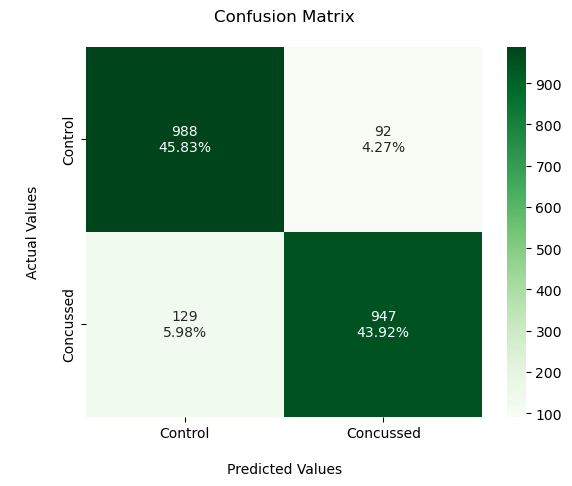

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

target_names = ['Control', 'Concussed']
report = classification_report(y_test, y_pred, target_names=target_names)
print("Classification Report:")
print(report)
cm = confusion_matrix(y_test, y_pred)

group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

ax = sns.heatmap(cm, fmt='', annot=labels, cmap='Greens')
ax.set_title('Confusion Matrix\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('\nActual Values\n')
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)

plt.show()


In [13]:
TP = 974
FN = 106
FP = 115
TN = 961

Precision = TP / (TP + FP)
Sensitivity = TP / (TP + FN)
Specificity = TN /(TN + FP)
False_Pos_Rate = FP / (TN + FP)
False_Neg_Rate = FN / (FN + TP)
F1_Score = (2*Precision*Sensitivity) / (Precision + Sensitivity)
Accuracy = (TP+TN) / (TP+FP+TN+FN)

precision = "{:.2f}".format(Precision)
sensitivity = "{:.2f}".format(Sensitivity)
specificity = "{:.2f}".format(Specificity)
false_pos_rate = "{:.2f}".format(False_Pos_Rate)
false_neg_rate = "{:.2f}".format(False_Neg_Rate)
f1_score = "{:.2f}".format(F1_Score)
accuracy = "{:.2f}".format(Accuracy)

print("Precision          :", precision)
print("Sensitivity        :", sensitivity)
print("Specificity        :", specificity)
print("F1-Score           :", f1_score)
print("False Positive Rate:", false_pos_rate)
print("False Negative Rate:", false_neg_rate)
print("Accuraccy          :", accuracy)

Precision          : 0.89
Sensitivity        : 0.90
Specificity        : 0.89
F1-Score           : 0.90
False Positive Rate: 0.11
False Negative Rate: 0.10
Accuraccy          : 0.90
